# Holt and Beyond - Forecasting Energy Consumption

### Introduction

Forecasting energy consumption is a critical task for energy companies to ensure that they can meet the demand for energy. It can play crucial role in planning, management, operations and utilization of resources. In this notebook, we will explore the Holt-Winters and other advanced forecasting techniques like ARIMA, SARIMA and Prophet to forecast energy consumption.

### Data Description

- **Datetime**: Monthly Dates from 01/1939 to 09/2019
- **ENERGY_INDEX**: Energy consumption

### Objective

- To forecast energy consumption using Holt-Winters and other advanced forecasting techniques.

### Evaluation Criteria

- We will use RMSE (Root Mean Squared Error) as the evaluation metric.

$$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}$$

### Table of Contents

1. Importing Libraries
2. Load and Understand Data
3. Feature Engineering
4. Exploratory Data Analysis
5. Data Preparation
6. Model Building and Evaluation
    - Holt-Winters
    - ARIMA
    - SARIMA
    - Prophet

## 1. Importing Libraries

In [2]:
import datetime
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
%matplotlib inline

#suppress warnings
import warnings
warnings.filterwarnings('ignore')

## 2. Load and Understand Data

In [3]:
df = pd.read_csv('../Datasets/time_series_data/energy_consumption.zip')

In [4]:
df.head()

,DATE,ENERGY_INDEX
0,01/1939,3.3842
1,02/1939,3.4100
2,03/1939,3.4875
3,04/1939,3.5133
4,05/1939,3.5133


In [4]:
df.shape

(969, 2)

In [5]:
df.dtypes

DATE             object
ENERGY_INDEX    float64
dtype: object

In [6]:
df.DATE = pd.to_datetime(df.DATE)

In [7]:
df.head()

,DATE,ENERGY_INDEX
0,1939-01-01,3.3842
1,1939-02-01,3.4100
2,1939-03-01,3.4875
3,1939-04-01,3.5133
4,1939-05-01,3.5133


In [8]:
df.dtypes

DATE            datetime64[ns]
ENERGY_INDEX           float64
dtype: object

In [9]:
df.set_index('DATE', inplace=True)

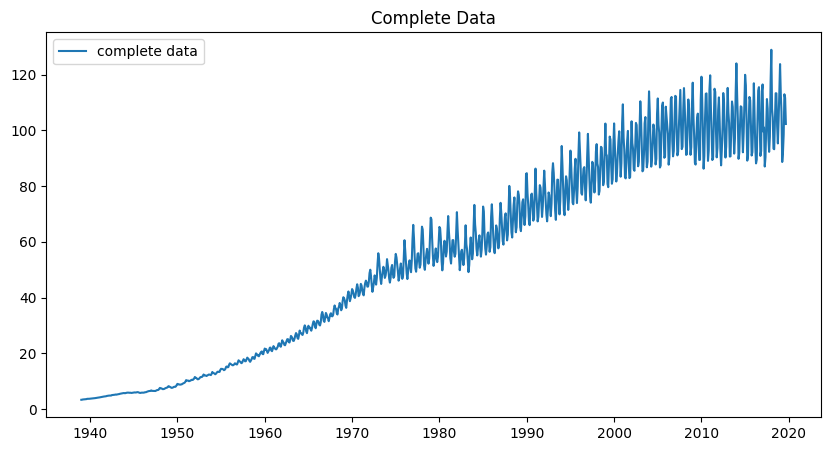

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))

plt.plot(df, label='complete data')
plt.legend(loc='best')
plt.title("Complete Data")
plt.show()

* We can see strong upward trend in data and also seasonality.

In [12]:
# Date Range
df.index.min(), df.index.max()

(Timestamp('1939-01-01 00:00:00'), Timestamp('2019-09-01 00:00:00'))

In [13]:
# Check for missing values
df.isnull().sum()

ENERGY_INDEX    0
dtype: int64

In [14]:
# Check missing dates
all_days = pd.date_range(start=df.index.min(), end=df.index.max(), freq='MS')
missing_days = all_days.difference(df.index)
missing_days

DatetimeIndex([], dtype='datetime64[ns]', freq='MS')

## 3. Feature Engineering

In [31]:
df.reset_index(inplace=True)
df['year'] = df['DATE'].dt.year
df['month'] = df['DATE'].dt.month
df['quarter'] = df['DATE'].dt.quarter

In [32]:
df.head()

,DATE,ENERGY_INDEX,year,month,quarter
0,1939-01-01,3.3842,1939,1,1
1,1939-02-01,3.4100,1939,2,1
2,1939-03-01,3.4875,1939,3,1
3,1939-04-01,3.5133,1939,4,2
4,1939-05-01,3.5133,1939,5,2


## 4. Exploratory Data Analysis

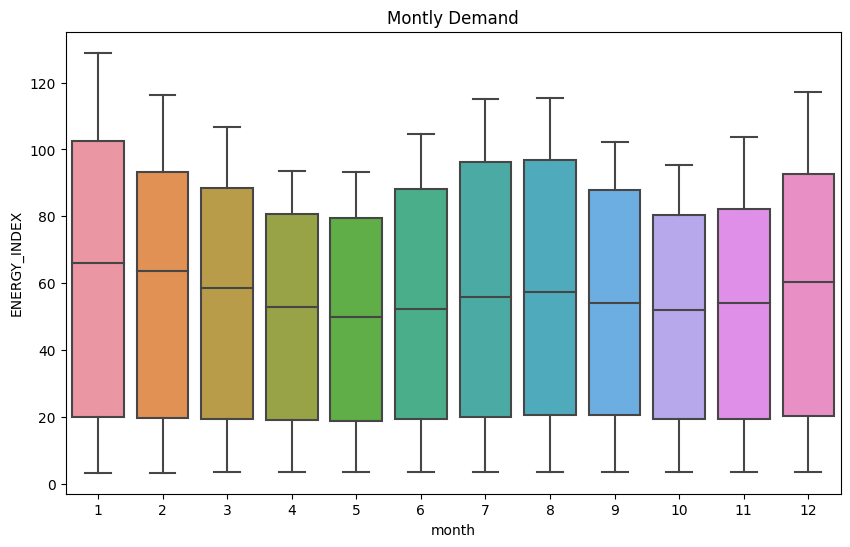

In [33]:
# boxplot for monthly demand
plt.figure(figsize=(10,6))

sns.boxplot(x=df['month'], y=df['ENERGY_INDEX'], )
plt.title('Montly Demand')
plt.show()

- We can see that energy consumption is in the fluctuating pattern.

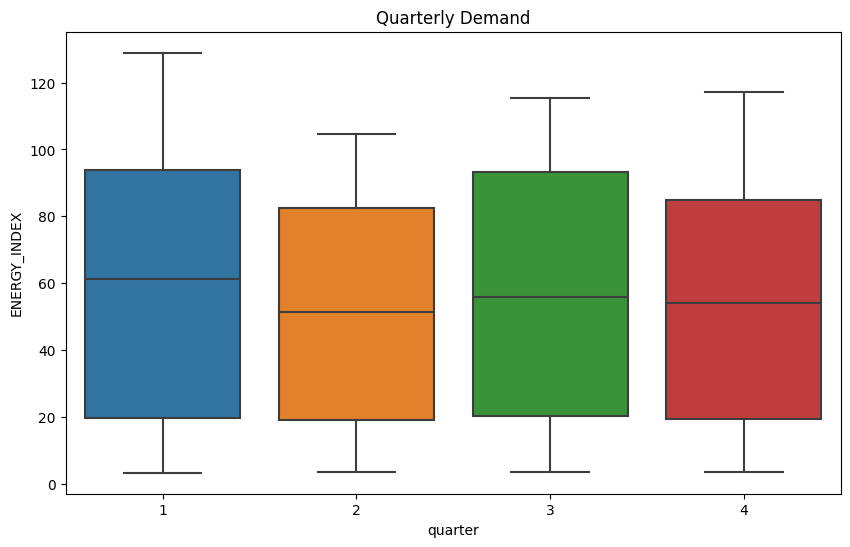

In [70]:
# boxplot for quarterly energy demand
plt.figure(figsize=(10,6))

sns.boxplot(x=df['quarter'], y=df['ENERGY_INDEX'], )
plt.title('Quarterly Demand')
plt.show()

* We can observe that the demand in 1st and 3rd quarter of the year is high and the demand in 2nd and 4th quarter of the year is low, which is due to the quarterly seasonal effect.

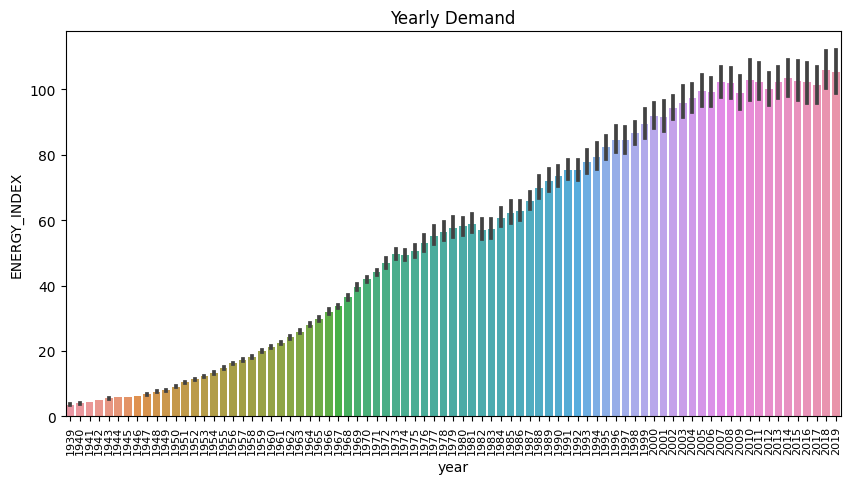

In [71]:
# Yearly average
fig, ax = plt.subplots(figsize=(10, 5))

sns.barplot(x=df['year'], y=df['ENERGY_INDEX'])
plt.xticks(rotation=90, fontsize=8)
plt.title("Yearly Demand")
plt.show()

- There is a strong upward trend in the data year by year.

* Let's decompose seasonality to comfirm monthly/quaterly seasonality

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [81]:
decomposed_series = seasonal_decompose(df.set_index('DATE')["ENERGY_INDEX"])

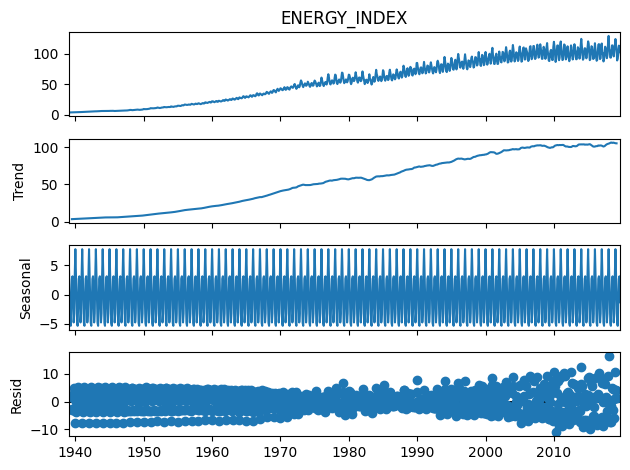

In [82]:
decomposed_series.plot()
plt.show()

* We can observe strong trend and seasonality in the data.

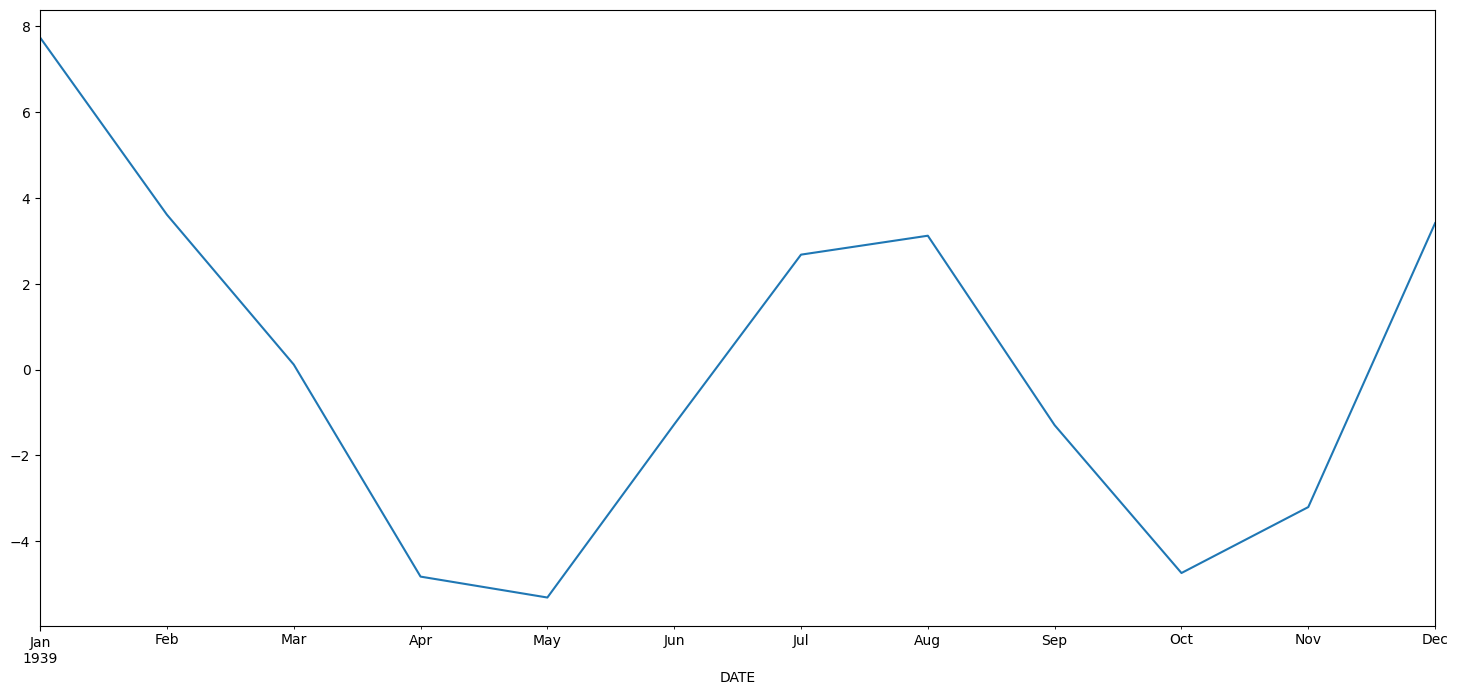

In [85]:
# CLoser look at the seasonal component
plt.figure(figsize=(18,8))
(decomposed_series.seasonal[0:12]).plot()
plt.show()

* We can confirm ~quarterly seasonality in the data.

## 5. Data Preparation

In [16]:
df.shape

(969, 1)

In [12]:
train_size = int(df.shape[0] * 0.8)

In [13]:
df_train = df[:train_size]
df_train.shape

(775, 1)

In [15]:
# df_train.set_index('DATE', inplace=True)

In [16]:
df_train.head()

,ENERGY_INDEX
DATE,
1939-01-01,3.3842
1939-02-01,3.4100
1939-03-01,3.4875
1939-04-01,3.5133
1939-05-01,3.5133


In [17]:
df_train.tail()

,ENERGY_INDEX
DATE,
2003-03-01,94.8015
2003-04-01,85.3124
2003-05-01,85.7418
2003-06-01,91.3695
2003-07-01,102.5243


In [18]:
df_test = df[train_size:]
df_test.shape

(194, 1)

In [20]:
# df_test.set_index('DATE', inplace=True)

In [21]:
df_test.head()

,ENERGY_INDEX
DATE,
2003-08-01,104.7716
2003-09-01,93.1841
2003-10-01,86.7534
2003-11-01,88.8280
2003-12-01,103.8162


In [22]:
df_test.tail()

,ENERGY_INDEX
DATE,
2019-05-01,91.9046
2019-06-01,98.4397
2019-07-01,112.9469
2019-08-01,111.6645
2019-09-01,102.2911


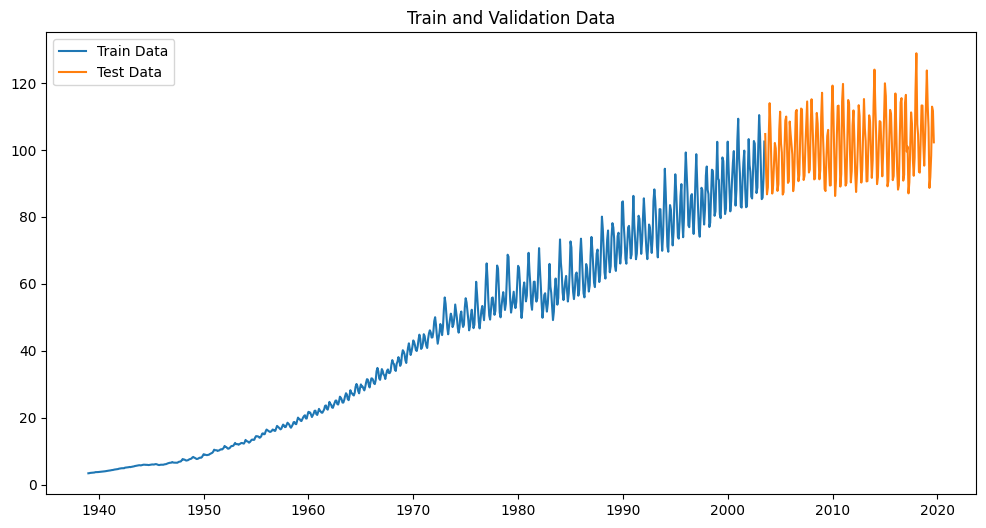

In [23]:
fig, ax = plt.subplots(figsize=(12, 6))

plt.plot(df_train.ENERGY_INDEX, label='Train Data')
plt.plot(df_test.ENERGY_INDEX, label='Test Data')
plt.legend(loc="best")
plt.title("Train and Validation Data")
plt.show()

## 6. Model Building and Evaluation

- We can see we have trend and seasonality in the data. So, we will use Holt-Winters, ARIMA, SARIMA and Prophet to forecast energy consumption which can handle trend and seasonality.

### Evaluation Metric

- We will use RMSE as the evaluation metric.

In [83]:
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

### Holt-Winters (Triple Exponential Smoothing)

- Triple exponential smoothing is used to forecast time series data with a trend and seasonality.

- Level

$$l(t) = alpha * (x(t) - s(t-L)) + (1 - alpha) * (l(t-1) + b(t-1))$$

- Trend

$$b(t) = beta * (l(t) - l(t-1)) + (1 - beta) * b(t-1)$$

- Seasonality

$$s(t) = gamma * (x(t) - l(t)) + (1 - gamma) * s(t-L)$$

$$L = seasonality component (1-day, 7-week, 30-month, 365-year)$$

- Forecast

$$F(t+h) = l(t) + h * b(t) + s(t-L+h)$$

$$h = 1, 2, 3, ...$$

In [84]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [120]:
model = ExponentialSmoothing(df_train['ENERGY_INDEX'], seasonal_periods=90, trend='add', seasonal='add')
fit = model.fit(smoothing_level=0.1, smoothing_trend=0.1, smoothing_seasonal=0.1)

df_test['Holt_Winter'] = fit.forecast(len(df_test))

In [121]:
df_test.head()

,ENERGY_INDEX,Holt_Winter
DATE,,
2003-08-01,104.7716,98.442134
2003-09-01,93.1841,95.595472
2003-10-01,86.7534,92.170116
2003-11-01,88.8280,92.201121
2003-12-01,103.8162,95.275318


In [122]:
model.params

{'smoothing_level': 0.1,
 'smoothing_trend': 0.1,
 'smoothing_seasonal': 0.1,
 'damping_trend': nan,
 'initial_level': 3.0415873767725095,
 'initial_trend': 0.06857520453116091,
 'initial_seasons': array([ 3.29398357,  1.38779403,  0.0739845 , -2.48756917, -2.16185345,
         0.71323389,  3.19513308,  2.11796464, -0.71917523, -2.8938982 ,
        -2.70271695,  0.04178812,  2.76364259,  1.54982531, -0.72990287,
        -2.70992169, -2.12403728,  0.83184682,  2.92546137,  2.80786985,
         0.29280879, -2.91488308, -2.67252392,  0.93116763,  3.22357738,
         1.53172622, -0.7560885 , -3.26236743, -2.7941855 ,  0.44208445,
         3.54340257,  2.78267118, -0.32186461, -2.85925865, -3.14129797,
         0.07098075,  2.77775712,  1.76817288, -0.22891589, -2.61624288,
        -2.50410618,  0.60785753,  3.46794784,  2.91783087,  0.23633268,
        -2.65127878, -2.41241068,  0.97177405,  4.48605541,  3.62684311,
         0.23987402, -2.74276536, -2.41184698,  0.93914314,  4.16990347,


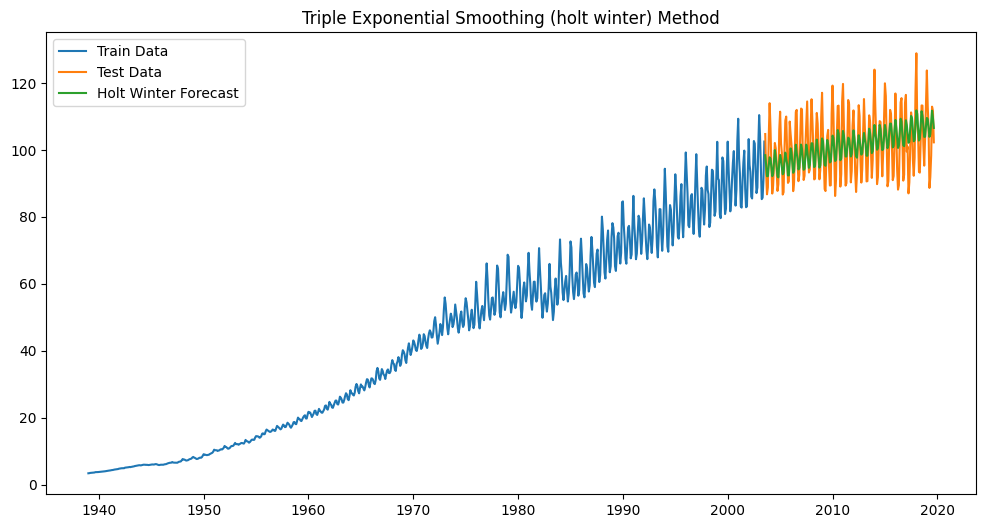

In [123]:
fig, ax = plt.subplots(figsize=(12, 6))

plt.plot(df_train.ENERGY_INDEX, label='Train Data')
plt.plot(df_test.ENERGY_INDEX, label='Test Data')
plt.plot(df_test['Holt_Winter'], label='Holt Winter Forecast')
plt.legend(loc='best')
plt.title("Triple Exponential Smoothing (holt winter) Method")
plt.show()

In [124]:
# RMSE
print("RMSE: ", rmse(df_test.ENERGY_INDEX, df_test.Holt_Winter))

RMSE:  7.266980077966138


- GREAT!!! Our model is performing well with RMSE of ~7.27.

#### Tuning Holt-Winters

In [119]:
# Tuning the Holt-Winters model
import itertools

param_grid = {
    "smoothing_level": [0.01, 0.02, 0.05, 0.1, 0.2, 0.5],
    "smoothing_trend": [0.01, 0.02, 0.03, 0.04, 0.1, 0.2],
    "smoothing_seasonal": [0.01, 0.02, 0.04, 0.1, 0.2],
    "seasonal_periods": [80,90,100],
    "seasonal": ["add", "mul"],
    "trend": ["add", "mul"],
}

# Generate all combinations of hyperparameters
param_combinations = list(itertools.product(
    param_grid["smoothing_level"],
    param_grid["smoothing_trend"],
    param_grid["smoothing_seasonal"],
    param_grid["seasonal_periods"],
    param_grid["seasonal"],
    param_grid["trend"]
))

print(f"Total Combinations: {len(param_combinations)}")

Total Combinations: 2160


In [124]:
def holt_optimizer(train_df, test_df, params):
    best_score = float("inf")
    best_params = None
    for i, params in tqdm.tqdm_notebook(enumerate(param_combinations)):
        smoothing_level, smoothing_trend, smoothing_seasonal, seasonal_periods, seasonal, trend = params
        model = ExponentialSmoothing(train_df["ENERGY_INDEX"], trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods)
        model = model.fit(smoothing_level=smoothing_level, smoothing_slope=smoothing_trend, smoothing_seasonal=smoothing_seasonal)

        y_pred = model.forecast(len(test_df))
        score = rmse(test_df["ENERGY_INDEX"], y_pred)

        if score < best_score:
            best_score = score
            best_params = params
        if i % 100 == 0:
            print(f"{i+1}/{len(param_combinations)} | RMSE: {score} | Best RMSE: {best_score}")

    return best_score, best_params

In [ ]:
best_score, best_params = holt_optimizer(df_train, df_test, param_combinations)

In [126]:
print(f"Best RMSE: {best_score} | Best Params: {best_params}")
print(f"Best Params: {best_params}")

Best RMSE: 5.334704520086752 | Best Params: (0.1, 0.04, 0.2, 90, 'mul', 'add')
Best Params: (0.1, 0.04, 0.2, 90, 'mul', 'add')


In [ ]:
# Train the model with the best parameters
model = ExponentialSmoothing(df_train['ENERGY_INDEX'], seasonal_periods=best_params[3], trend=best_params[5], seasonal=best_params[4],)
fit = model.fit(smoothing_level=best_params[0], smoothing_trend=best_params[1], smoothing_seasonal=best_params[2], )

df_test['Holt_Winter'] = fit.forecast(len(df_test))

In [128]:
print("RMSE: ", rmse(df_test.ENERGY_INDEX, df_test.Holt_Winter))

RMSE:  5.334704520086752


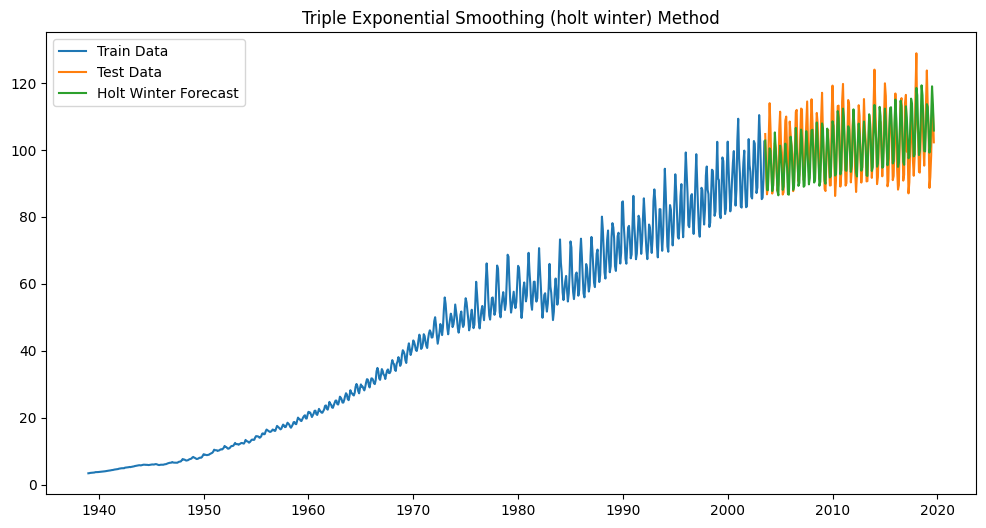

In [129]:
fig, ax = plt.subplots(figsize=(12, 6))

plt.plot(df_train.ENERGY_INDEX, label='Train Data')
plt.plot(df_test.ENERGY_INDEX, label='Test Data')
plt.plot(df_test['Holt_Winter'], label='Holt Winter Forecast')
plt.legend(loc='best')
plt.title("Triple Exponential Smoothing (holt winter) Method")
plt.show()

### SARIMA (Seasonal AutoRegressive Integrated Moving Average)

- SARIMA is an extension of ARIMA that explicitly models the seasonal element in univariate time series data.

- SARIMA model is defined by 7 parameters: p, d, q, P, D, Q, m.

- p is the number of lag observations included in the model (lag order).

- d is the number of times that the raw observations are differenced (degree of differencing).

- q is the size of the moving average window (order of moving average).

- P is the number of seasonal lag observations included in the model (lag order).

- D is the number of times that the seasonal observations are differenced (degree of seasonal differencing).

- Q is the size of the seasonal moving average window (order of seasonal moving average).

- m is the number of time steps for a single seasonal period.

##### Stationarity

- A stationary time series is one whose properties do not depend on the time at which the series is observed.

    - **Strict Stationary**: A strict stationary series satisfies the mathematical definition of a stationary process. For a strict stationary series, the mean, variance and covariance are constant over time.

    - **Trend Stationary**: A series that has no unit root but exhibit a trend is referred to as trend stationary.

##### Tests for Stationarity
- Visual Test


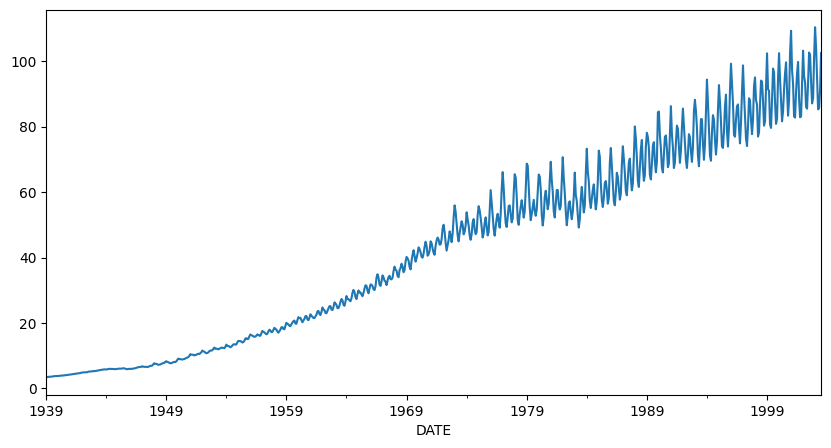

In [25]:
fig, ax = plt.subplots(figsize=(10, 5))

df_train['ENERGY_INDEX'].plot(ax=ax, label='Train Data')
plt.show()

- Statistical Test
    - Augmented Dickey-Fuller (ADF) Test
        - Null Hypothesis (H0): The time series is non-stationary.
        - Alternate Hypothesis (H1): The time series is stationary.

    - Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test
        - Null Hypothesis (H0): The time series is trend stationary.
        - Alternate Hypothesis (H1): The time series is non-stationary.

In [26]:
# ADF Test
from statsmodels.tsa.stattools import adfuller

def check_adf(df):
    result = adfuller(df)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [27]:
# KPSS Test
from statsmodels.tsa.stattools import kpss

def check_kpss(df):
    result = kpss(df)
    print('KPSS Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[3].items():
        print('\t%s: %.3f' % (key, value))

In [47]:
check_adf(df_train['ENERGY_INDEX'])
check_kpss(df_train['ENERGY_INDEX'])

ADF Statistic: 1.589352
p-value: 0.997825
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
KPSS Statistic: 4.390342
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


/tmp/ipykernel_47897/1182014096.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(df)


##### Making the series stationary

- Differencing
    - Differencing is a method of transforming a time series dataset.
    - It calculates the difference between each data point and the one that preceded it.
    - Differencing can help stabilize the mean of a time series by removing changes in the level of a time series, and therefore eliminating (or reducing) trend and seasonality.

$$x(t) = x(t) - x(t-1)$$

- Seasonal Differencing
    - Seasonal differencing is the difference between an observation and the corresponding observation in the previous season.

$$x(t) = x(t) - x(t-L)$$
$$L = seasonality component (1-day, 7-week, 30-month, 365-year)$$

- Log Transformation
    - Log transformation can help stabilize the variance of a time series.
    - Log transformation can help make a time series more stationary.

$$x(t) = log(x(t))$$

- Box-Cox Transformation
    - Box-Cox transformation is a family of power transformations defined by a parameter lambda.
    - Box-Cox transformation can help stabilize the variance of a time series.

$$
x(t) = 
\begin{cases} 
\frac{x(t)^\lambda - 1}{\lambda} & \text{if } \lambda \neq 0 \\
\log(x(t)) & \text{if } \lambda = 0 
\end{cases}
$$

- Differencing and Seasonal Differencing

In [48]:
df_train["energy_diff"] = df_train["ENERGY_INDEX"].diff()

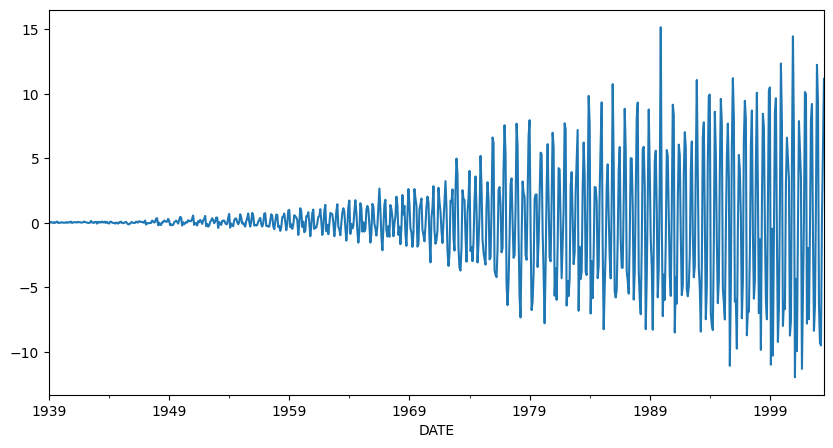

In [49]:
fig, ax = plt.subplots(figsize=(10, 5))

df_train['energy_diff'].plot(ax=ax, label='Train Data')
plt.show()

In [54]:
df_train["seasonal_diff"] = df_train["ENERGY_INDEX"].diff(90)

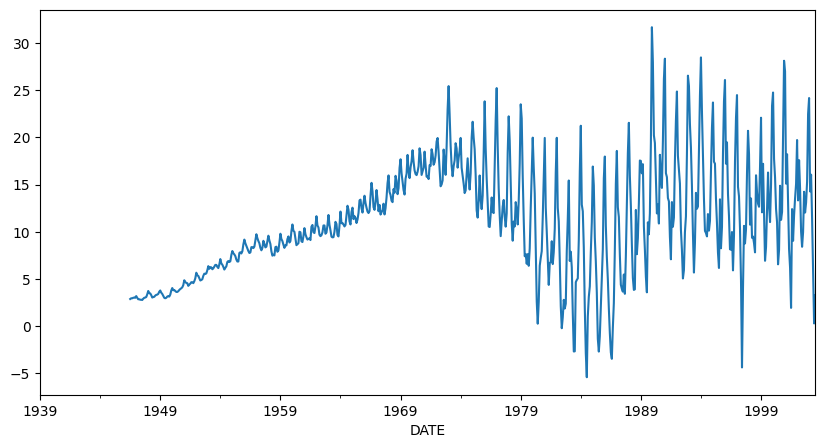

In [55]:
fig, ax = plt.subplots(figsize=(10, 5))

df_train['seasonal_diff'].plot(ax=ax, label='Train Data')
plt.show()

- Log Transformation with Differencing

In [61]:
df_train["enery_log"] = np.log(df_train["ENERGY_INDEX"])
df_train["enery_log_diff"] = df_train["enery_log"].diff().diff()

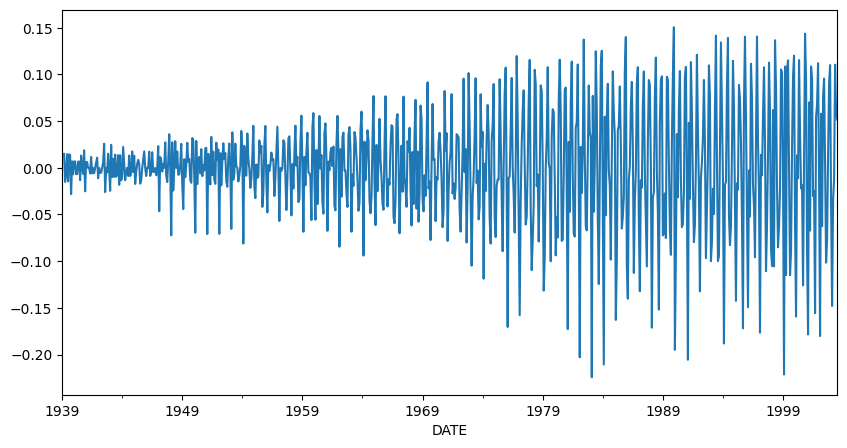

In [62]:
fig, ax = plt.subplots(figsize=(10, 5))

df_train['enery_log_diff'].plot(ax=ax, label='Train Data')
plt.show()

- Check Stationarity

In [63]:
check_adf(df_train['enery_log_diff'].dropna())
check_kpss(df_train['enery_log_diff'].dropna())

ADF Statistic: -8.754724
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
KPSS Statistic: 0.077756
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


/tmp/ipykernel_47897/1182014096.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(df)


##### ACF (AutoCorrelation Function) and PACF (Partial AutoCorrelation Function)

- Correlation
    - Correlation is a statistical measure that describes the strength of the relationship between two variables.

- ACF (AutoCorrelation Function) is a measure of the correlation between the time series and a lagged version of itself.

- PACF (Partial AutoCorrelation Function) is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed.


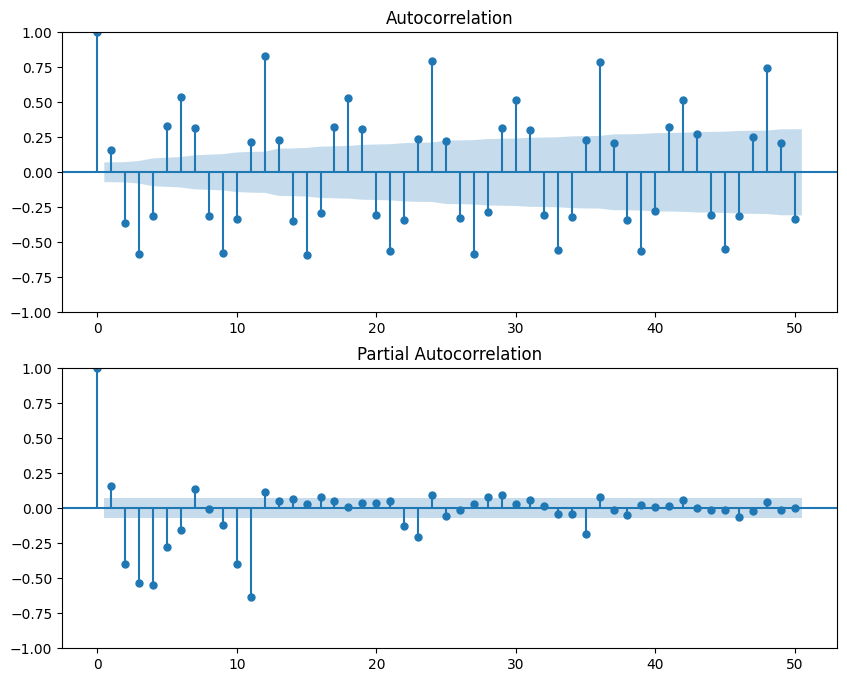

In [64]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(df_train['enery_log_diff'].dropna(), lags=50, ax=ax[0])
plot_pacf(df_train['enery_log_diff'].dropna(), lags=50, ax=ax[1])
plt.show()

- ACF and PACF plots are used to determine the order of AR and MA terms in the ARIMA model.

- p -> 3
- d -> 2
- q -> 4

- Log Transformation with Seasonal Differencing

In [130]:
df_train["seasonal_log_diff"] = df_train["enery_log"].diff(3).diff(3).diff(3)

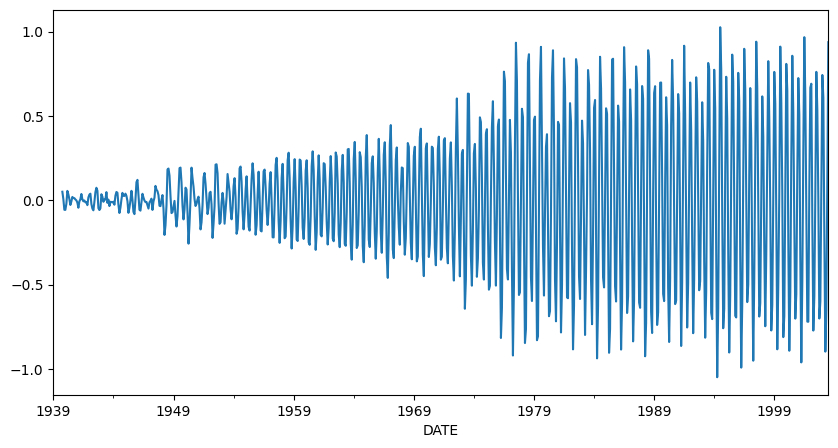

In [131]:
fig, ax = plt.subplots(figsize=(10, 5))

df_train['seasonal_log_diff'].plot(ax=ax, label='Train Data')
plt.show()

- Check Stationarity

In [133]:
check_adf(df_train['seasonal_log_diff'].dropna())
check_kpss(df_train['seasonal_log_diff'].dropna())

ADF Statistic: -12.964347
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
KPSS Statistic: 0.047723
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


/tmp/ipykernel_47897/1182014096.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(df)


- ACF and PACF plots

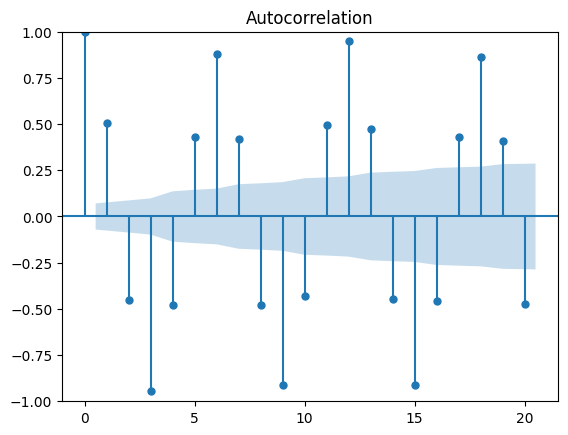

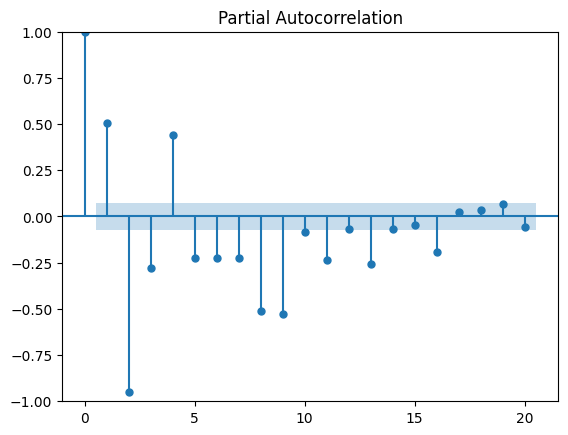

In [135]:
plot_acf(df_train['seasonal_log_diff'].dropna(), lags=20)
plot_pacf(df_train['seasonal_log_diff'].dropna(), lags=20)
plt.show()

- P -> 3
- D -> 3
- Q -> 2

- SARIMA Model

In [136]:
# SARIMA Model
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [263]:
df_train = df_train.asfreq('MS')
df_test = df_test.asfreq('MS')

sarima_model = SARIMAX(df_train['enery_log'], order=(3, 2, 3), seasonal_order=(2, 3, 4, 4),)
sarima_fit = sarima_model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.37098D-01    |proj g|=  4.76700D+00


 This problem is unconstrained.



At iterate    5    f= -1.87816D+00    |proj g|=  1.98771D+01

At iterate   10    f= -1.94218D+00    |proj g|=  3.08373D+00

At iterate   15    f= -1.98138D+00    |proj g|=  2.79753D-01

At iterate   20    f= -2.02094D+00    |proj g|=  1.26726D+00

At iterate   25    f= -2.02762D+00    |proj g|=  3.41543D+00

At iterate   30    f= -2.06902D+00    |proj g|=  2.73985D-01

At iterate   35    f= -2.07043D+00    |proj g|=  9.28229D-01

At iterate   40    f= -2.08769D+00    |proj g|=  1.11567D+00

At iterate   45    f= -2.15598D+00    |proj g|=  5.31112D-01

At iterate   50    f= -2.15772D+00    |proj g|=  3.69055D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/rishabh/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [264]:
df_test['SARIMA'] = np.exp(sarima_fit.forecast(len(df_test)))

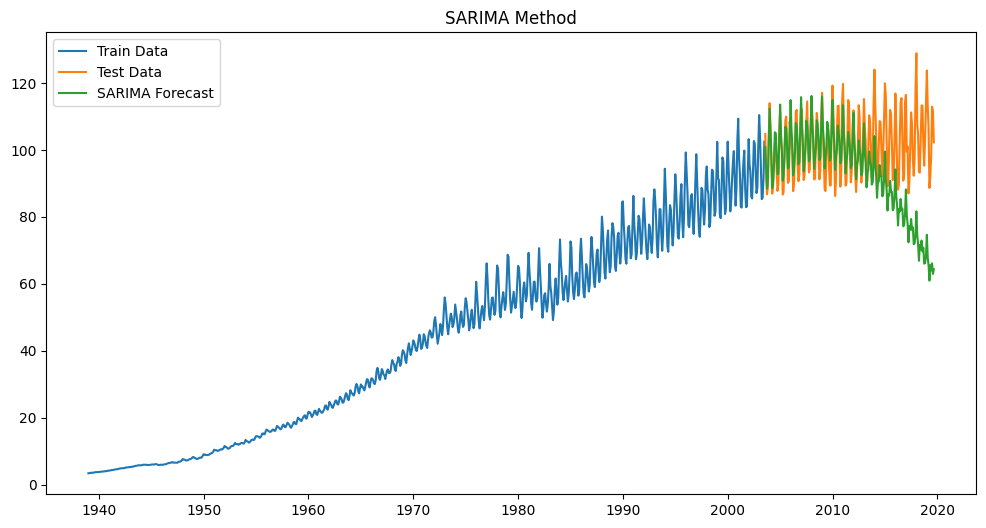

In [265]:
fig, ax = plt.subplots(figsize=(12, 6))

plt.plot(df_train.ENERGY_INDEX, label='Train Data')
plt.plot(df_test.ENERGY_INDEX, label='Test Data')
plt.plot(df_test['SARIMA'], label='SARIMA Forecast')
plt.legend(loc='best')
plt.title("SARIMA Method")
plt.show()

In [266]:
# RMSE
print("RMSE: ", rmse(df_test.ENERGY_INDEX, df_test.SARIMA))

RMSE:  16.397599478455056


In [ ]:
# Fine Tune SARIMA Model
import itertools

param_grid = {
    "p": [1, 2, 3],
    "d": [1, 2],
    "q": [1, 2, 3],
    "P": [1, 2, 3],
    "D": [1, 2],
    "Q": [1, 2, 3, 4],
    "s": [4],
}

# Generate all combinations of hyperparameters
param_combinations = list(itertools.product(
    param_grid["p"],
    param_grid["d"],
    param_grid["q"],
    param_grid["P"],
    param_grid["D"],
    param_grid["Q"],
    param_grid["s"],
))

print(f"Total Combinations: {len(param_combinations)}")

def sarima_optimizer(train_df, test_df, params):
    best_score = float("inf")
    best_params = None
    for i, params in tqdm.tqdm_notebook(enumerate(param_combinations)):
        p, d, q, P, D, Q, s = params
        model = SARIMAX(train_df["enery_log"], order=(p, d, q), seasonal_order=(P, D, Q, s))
        model = model.fit()

        y_pred = np.exp(model.forecast(len(test_df)))
        score = rmse(test_df["ENERGY_INDEX"], y_pred)

        if score < best_score:
            best_score = score
            best_params = params
        if i % 100 == 0:
            print(f"{i+1}/{len(param_combinations)} | RMSE: {score} | Best RMSE: {best_score}")

    return best_score, best_params

best_score, best_params = sarima_optimizer(df_train, df_test, param_combinations)
print(f"Best RMSE: {best_score} | Best Params: {best_params}")

In [269]:
print(f"Best RMSE: {best_score} | Best Params: {best_params}")

Best RMSE: 3.4912823021581354 | Best Params: (1, 1, 1, 2, 2, 4, 4)


In [270]:
# Build SARIMA Model with best parameters
sarima_model = SARIMAX(df_train['enery_log'], order=(best_params[0], best_params[1], best_params[2]), seasonal_order=(best_params[3], best_params[4], best_params[5], best_params[6]))
sarima_fit = sarima_model.fit()

df_test['SARIMA'] = np.exp(sarima_fit.forecast(len(df_test)))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.78405D-01    |proj g|=  9.32219D-01


 This problem is unconstrained.



At iterate    5    f= -1.55061D+00    |proj g|=  1.91942D+00

At iterate   10    f= -1.74509D+00    |proj g|=  5.00861D-01

At iterate   15    f= -1.78161D+00    |proj g|=  2.26768D+00

At iterate   20    f= -1.89899D+00    |proj g|=  3.35985D-01

At iterate   25    f= -2.10928D+00    |proj g|=  9.24613D+00

At iterate   30    f= -2.33575D+00    |proj g|=  1.99036D+00

At iterate   35    f= -2.35695D+00    |proj g|=  8.35986D-01

At iterate   40    f= -2.39953D+00    |proj g|=  1.41655D+00

At iterate   45    f= -2.43606D+00    |proj g|=  6.92658D-01

At iterate   50    f= -2.43825D+00    |proj g|=  2.84399D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/rishabh/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


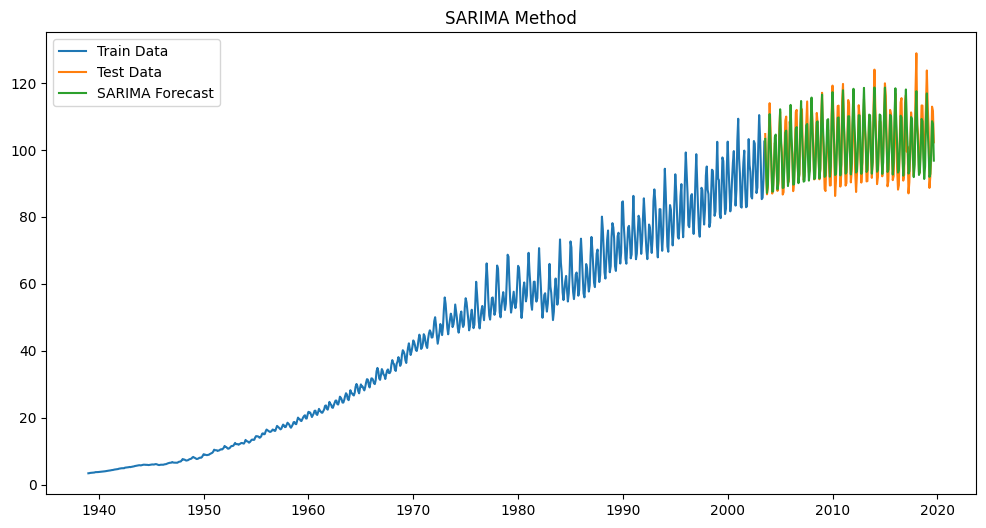

In [271]:
fig, ax = plt.subplots(figsize=(12, 6))

plt.plot(df_train.ENERGY_INDEX, label='Train Data')
plt.plot(df_test.ENERGY_INDEX, label='Test Data')
plt.plot(df_test['SARIMA'], label='SARIMA Forecast')
plt.legend(loc='best')
plt.title("SARIMA Method")
plt.show()

### Prophet

- Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects.  

In [272]:
from prophet import Prophet

df_prophet = df_train.copy()
df_prophet.reset_index(inplace=True)
df_prophet.rename(columns={'DATE': 'ds', 'ENERGY_INDEX': 'y'}, inplace=True)

prophet_model = Prophet()
prophet_model.fit(df_prophet)

future = prophet_model.make_future_dataframe(periods=len(df_test), freq='MS')

forecast = prophet_model.predict(future)

df_test['Prophet'] = forecast['yhat'].values[-len(df_test):]

20:52:11 - cmdstanpy - INFO - Chain [1] start processing
20:52:12 - cmdstanpy - INFO - Chain [1] done processing


In [274]:
# RMSE
print("RMSE: ", rmse(df_test.ENERGY_INDEX, df_test.Prophet))

RMSE:  14.154708295370844


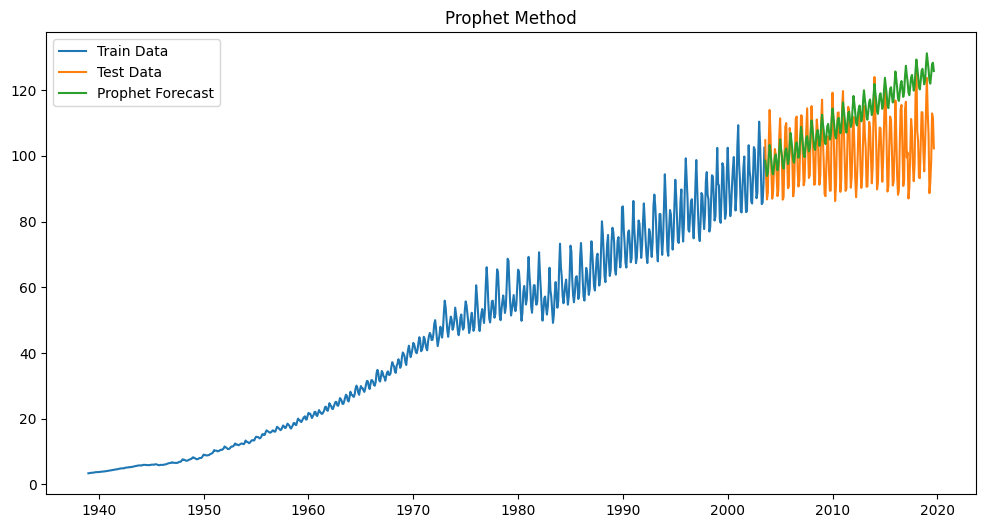

In [273]:
fig, ax = plt.subplots(figsize=(12, 6))

plt.plot(df_train.ENERGY_INDEX, label='Train Data')
plt.plot(df_test.ENERGY_INDEX, label='Test Data')
plt.plot(df_test['Prophet'], label='Prophet Forecast')
plt.legend(loc='best')
plt.title("Prophet Method")
plt.show()

In [275]:
# Fine Tune Prophet Model
param_grid = {
    "seasonality_mode": ["additive", "multiplicative"],
    "changepoint_prior_scale": [0.01, 0.1, 0.5, 1.0],
    "seasonality_prior_scale": [0.01, 0.1, 0.5, 1.0],
    "holidays_prior_scale": [0.01, 0.1, 0.5, 1.0],
}

# Generate all combinations of hyperparameters
param_combinations = list(itertools.product(
    param_grid["seasonality_mode"],
    param_grid["changepoint_prior_scale"],
    param_grid["seasonality_prior_scale"],
    param_grid["holidays_prior_scale"],
))

print(f"Total Combinations: {len(param_combinations)}")

Total Combinations: 128


In [ ]:

def prophet_optimizer(train_df, test_df, params):
    best_score = float("inf")
    best_params = None
    for i, params in tqdm.tqdm_notebook(enumerate(param_combinations)):
        seasonality_mode, changepoint_prior_scale, seasonality_prior_scale, holidays_prior_scale = params
        model = Prophet(seasonality_mode=seasonality_mode, changepoint_prior_scale=changepoint_prior_scale, seasonality_prior_scale=seasonality_prior_scale, holidays_prior_scale=holidays_prior_scale)
        model.fit(train_df)

        future = model.make_future_dataframe(periods=len(test_df), freq='MS')
        forecast = model.predict(future)

        y_pred = forecast['yhat'].values[-len(test_df):]
        score = rmse(test_df["ENERGY_INDEX"], y_pred)

        if score < best_score:
            best_score = score
            best_params = params
        if i % 100 == 0:
            print(f"{i+1}/{len(param_combinations)} | RMSE: {score} | Best RMSE: {best_score}")

    return best_score, best_params

best_score, best_params = prophet_optimizer(df_prophet, df_test, param_combinations)
print(f"Best RMSE: {best_score} | Best Params: {best_params}")

In [278]:
# Build Prophet Model with best parameters
model = Prophet(seasonality_mode=best_params[0], changepoint_prior_scale=best_params[1], seasonality_prior_scale=best_params[2], holidays_prior_scale=best_params[3])
model.fit(df_prophet)

future = model.make_future_dataframe(periods=len(df_test), freq='MS')
forecast = model.predict(future)

df_test['Prophet'] = forecast['yhat'].values[-len(df_test):]

20:58:10 - cmdstanpy - INFO - Chain [1] start processing
20:58:11 - cmdstanpy - INFO - Chain [1] done processing


In [279]:
# RMSE
print("RMSE: ", rmse(df_test.ENERGY_INDEX, df_test.Prophet))

RMSE:  11.477949067855821


## Conclusion

- We have successfully forecasted energy consumption using Holt-Winters, ARIMA, SARIMA and Prophet.

- SARIMA model is performing well with RMSE of ~Best RMSE: 3.4912823021581354 | Best Params: (1, 1, 1, 2, 2, 4, 4)

* Let's train on entire dataset and predict for th enext 3 years.

In [283]:
# Best Params: (1, 1, 1, 2, 2, 4, 4)
best_params = (1, 1, 1, 2, 2, 4, 4)

model = SARIMAX(df_train['enery_log'], order=(best_params[0], best_params[1], best_params[2]), seasonal_order=(best_params[3], best_params[4], best_params[5], best_params[6]))
sarima_fit = model.fit()

# Forcast for next 3 years
future = sarima_fit.forecast(steps=36)

# Convert log values to original scale
future = np.exp(future)

# Create a new date range
date_range = pd.date_range(start=df_test.index[-1], periods=36, freq='MS')

# Create a new dataframe
future_df = pd.DataFrame({'DATE': date_range, 'ENERGY_INDEX': future}).set_index('DATE')

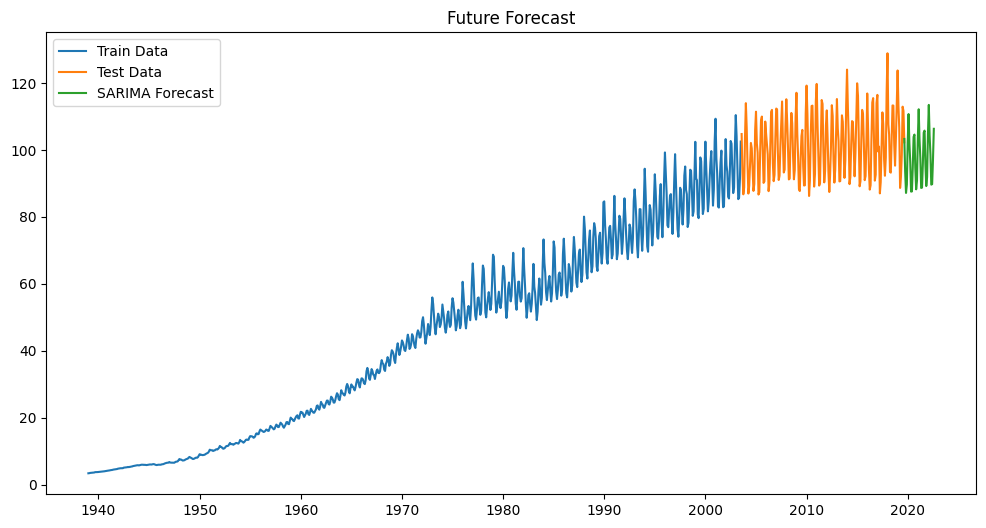

In [284]:
fig, ax = plt.subplots(figsize=(12, 6))

plt.plot(df_train.ENERGY_INDEX, label='Train Data')
plt.plot(df_test.ENERGY_INDEX, label='Test Data')
plt.plot(future_df.ENERGY_INDEX, label='SARIMA Forecast')

plt.legend(loc='best')
plt.title("Future Forecast")
plt.show()